# Using a new function to evaluate or evaluating a new acquisition function

In this notebook we describe how to integrate a new fitness function to the testing framework as well as how to integrate a new acquisition function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import egreedy

## New fitness function

The `perform_experiment` function in the `optimizer` class, used to carry out the optimisation runs (see its docstring and `run_all_experiments.py` for usage examples), imports a fitness **class**. This class, when instantiated is also callable. The class is imported from the `test_problems` module. Therefore, the easiest way to incorperate your own fitness function is to add it to the `test_problems` module by creating a python file in the `egreedy/test_problems/` directory and adding a line importing it into the namespace (see `egreedy/test_problems/__init__.py` for examples) so that it can be directly imported from `test_problems`.

If, for example, your fitness class is called `xSquared` and is located in the file `xs.py`, you would place the python file in the directory `egreedy/test_problems` and add the line:
```
from .xs import xSquared
```
to the `egreedy/test_problems/__init__.py` file.

We will now detail how to structure your fitness class and show the required class methods by creating a new fitness class for the function
\begin{equation}
f( \mathbf{x} ) = \sum_{i=1}^2 x_i^2,
\end{equation}
where $\mathbf{x} \in [-5, 5]^2.$

In [2]:
class xSquared:
    """Example fitness class.
    
    .. math::
        f(x) = \sum_{i=1}^2 x_i^2
        
    This demonstration class shows all the required attributes and 
    functionality of the fitness function class.
    """
    
    def __init__(self):
        """Initialisation function.
        
        This is called when the class is instantiated and sets up its
        attributes as well as any other internal variables that may
        be needed.
        """
        # problem dimensionality
        self.dim = 2
        
        # lower and upper bounds for each dimension (must be numpy.ndarray)
        self.lb = np.array([-5., -5.])
        self.ub = np.array([5., 5.])
        
        # location(s) of the optima (optional - not always known)
        self.xopt = np.array([0.])
        
        # its/thier fitness value(s)
        self.yopt = np.array([0.])
        
        # callable constraint function for the problem - should return
        # True if the argument value is **valid** - if no constraint function
        # is required then this can take the value of None
        self.cf = None
        
    def __call__(self, x):
        """Main callable function.
        
        This is called after the class is instantiated, e.g.
        >>> f = xSquared()
        >>> f(np.array([2., 2.]))
        array([8.])
        
        Note that it is useful to have a function that is able deal with
        multiple inputs, which should a numpy.ndarray of shape (N, dim)
        """
        # ensure the input is at least 2d, this will cause one-dimensional
        # vectors to be reshaped to shape (1, dim)
        x = np.atleast_2d(x)
        
        # evaluate the function
        val = np.sum(np.square(x), axis=1)
        
        # return the evaluations
        return val

This class can then either be placed in the directories discussed above and used for evaluating multiple techniques on it or used for testing purposes.

### Optimising the new test function with an acquistion function

The following code outlines how to optimise your newly created test function with the $\epsilon$-greedy with Pareto front selection ($\epsilon$-PF) algorithm.

In [3]:
from pyDOE2 import lhs

# ---- instantiate the test problem
f = xSquared()

# ---- Generate testing data by Latin hypercube sampling across the domain
n_training = 2 * f.dim

# LHS sample in [0, 1]^2 and rescale to problem domain
Xtr = lhs(f.dim, n_training, criterion='maximin')
Xtr = (f.ub - f.lb) * Xtr + f.lb

# expensively evaluate and ensure shape is (n_training, 1)
Ytr = np.reshape(f(Xtr), (n_training, 1))

# ---- Select an acquistion function with optimiser.
#      In this case we select e-greedy with Pareto front selection (e-PF)
#      known as eFront.
#
#      All the acqusition functions have the same parameters:
#      lb : lower-bound constraints (numpy.ndarray)
#      ub : upper-bound constraints (numpy.ndarray)
#      acq_budget : max number of calls to the GP model
#      cf : callable function constraint function that returns True if
#           the argument vector is VALID. Optional, has a value of None
#           if not used
#      acquisition_args : optional dictionary containing key:value pairs
#                         of arguments to a specific acqutision function.
#                         e.g. for an e-greedy method then the dict
#                        {'epsilon': 0.1} would dictate the epsilon value.

#      e-greedy with Pareto front selection (e-PF), known as eFront
from egreedy.acquisition_functions import eFront


# instantiate the optimiser with a budget of 5000d and epsilon = 0.1
acq_budget = 5000 * f.dim
acquisition_args = {'epsilon': 0.1}

acq_func = eFront(lb=f.lb, ub=f.ub, cf=None, acq_budget=acq_budget,
                  acquisition_args=acquisition_args)

# ---- Perform the bayesian optimisation loop for a total budget of 20
#      function evaluations (including those used for LHS sampling)
total_budget = 20

while Xtr.shape[0] < total_budget:
    # perform one iteration of BO:
    # this returns the new location and function value (Xtr, Ynew) as well
    # as the trained model used to select the new location
    Xnew, Ynew, model = egreedy.optimizer.perform_BO_iteration(Xtr,
                                                               Ytr,
                                                               f,
                                                               acq_func,
                                                               verbose=True)
    # augment the training data and repeat
    Xtr = np.concatenate((Xtr, np.atleast_2d(Xnew)))
    Ytr = np.concatenate((Ytr, np.atleast_2d(Ynew)))
    
    print('Best function value so far: {:g}'.format(np.min(Ytr)))
    print()

Training a GP model with 4 data points.
Optimising the acquisition function.
Expensively evaluating the new selected location.
New location  : [ 4.99999811 -4.10315199]
Function value: 41.8358
Best function value so far: 6.56671

Training a GP model with 5 data points.
Optimising the acquisition function.
Expensively evaluating the new selected location.
New location  : [ 0.54164842 -1.28198671]
Function value: 1.93687
Best function value so far: 1.93687

Training a GP model with 6 data points.
Optimising the acquisition function.
Expensively evaluating the new selected location.
New location  : [ 0.48462315 -0.71303977]
Function value: 0.743285
Best function value so far: 0.743285

Training a GP model with 7 data points.
Optimising the acquisition function.
Expensively evaluating the new selected location.
New location  : [ 0.39020808 -0.2072067 ]
Function value: 0.195197
Best function value so far: 0.195197

Training a GP model with 8 data points.
Optimising the acquisition function.

The plot below shows the difference between the best seen function value and the true minimum, i.e. $|f^\star - f_{min}|$, over each iteration.

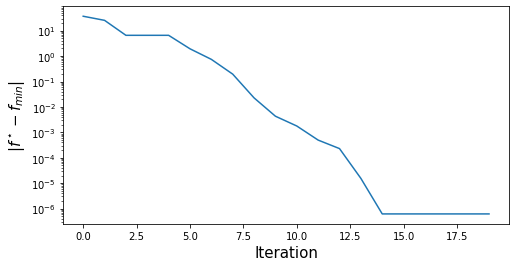

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.semilogy(np.minimum.accumulate(np.abs(Ytr - f.yopt)))
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('$|f^\star - f_{min}|$', fontsize=15)
plt.show()

## New acquisition function

We now detail how to create your own acquistion function class and integrate it into the testing suite.

In a similar manner to the fitness function classes, the acquistion function classes are imported from the `egreedy.acquisition_functions` module, with the specific classes avaliable determined by the `__ini__.py` file in the same module. 

If, for example, your acquistion function class is called `greed` and is located in the file `gr.py`, you would place the python file in the directory `egreedy/acquisition_functions` and add the line:
```
from .gr import greed
```
to the `egreedy/acquisition_functions/__init__.py` file.

The python file `egreedy/acquisition_functions/acq_func_optimisers.py` contains base classes for the acquistion function classes. We will now demonstrate how to implement two simple acquistion functions and then show how to optimise one of the test functions included in the suite.

The `BaseOptimiser` class is the base acquisition function class that implements the standard interface for acquisition function optimizers. It only contains an initialisation function with several arguments:

- lb: lower-bound constraint
- ub: upper-bound constraint
- acq_budget : maximum number of calls to the gp
- cf : callable constraint function that returns True if the argument decision vector is VALID (optional, default value: None)
- acquisition_args : Optional dictionary containing additional arguments that are unpacked into key=value arguments for an internal acqusition function; e.g. {'epsilon':0.1}.

The `ParetoFrontOptimiser` class implements the base class as well as an additional function named `get_front(model)` that takes in a GPRegression model from GPy and approximates its pareto front of model prediction and uncertainty. It returns the decision vectors belonging to the members of the front, an array containing corresponding their predicted value, and an array contaiing the prediction uncertainty.

We first create a simple acqusition function, extending the base class, that generates uniform samples in space and uses the GP's mean prediction to select the best (lowest value) predicted location.

In [5]:
from egreedy.acquisition_functions.acq_func_optimisers import BaseOptimiser

class greedy_sample(BaseOptimiser):
    """Greedy function that uniformly samples the GP posterior
    and returns the location with the best (lowest) mean predicted value.
    """
    
    # note we do not need to implement an __init__ method because the
    # base class already does this. Here we will include a commented
    # version for clarity.
#     def __init__(self, lb, ub, acq_budget, cf=None, acquisition_args={}):
#         self.lb = lb
#         self.ub = ub
#         self.cf = cf
#         self.acquisition_args = acquisition_args
#         self.acq_budget = acq_budget

    def __call__(self, model):
        """Returns the location with the best (lowest) predicted value
        after uniformly sampling decision space.
        """
        
        # generate samples
        X = np.random.uniform(self.lb, self.ub,
                              size=(acq_budget, self.lb.size))
        
        # evaluate them with the gp
        mu, sigmasqr = model.predict(X, full_cov=False)
        
        # find the index of the best value
        argmin = np.argmin(mu.flat)
        
        # return the best found value
        return X[argmin, :]

In [6]:
from egreedy.acquisition_functions.acq_func_optimisers import ParetoFrontOptimiser


class greedy_pfront(ParetoFrontOptimiser):
    """Exploitative method that calculates the approximate Pareto front
    of a GP model and returns the Pareto set member that has the best
    (lowest) predicted value.
    """
    
    # again here we do not need to implement an __init__ method.
    
    def __call__(self, model):
        """Returns the location with the best (lowest) predicted value
        from the approximate Pareto set of the GP's predicted value and
        its corresponding uncertainty.
        """
        
        # approximate the pareto set; here X are the locations of the
        # members of the set and mu and sigma are their predicted values
        # and uncertainty
        X, mu, sigma = self.get_front(model)
        
        # find the index of the best value
        argmin = np.argmin(mu.flat)
        
        # return the best found value
        return X[argmin, :]

We now create a similar script to the one used above in the function example. This time we will optimise the `push4` function included in the test suite and load the training data associated with the first run all techniques evaluated in the paper carried out. 

Note that in this case the training data contains arguments to be passed into the function during instantiation. This is because the `push4` runs are evaluated on a *problem instance* basis.

In [7]:
from egreedy.test_problems import push4

# ---- optimisation run details
problem_name = 'push4'
run_no = 1
acq_budget = 5000 * 4  # because the problem dimensionality is 4

total_budget = 50

# ---- load the training data
data_file = f'training_data/{problem_name:}_{run_no:}.npz'

with np.load(data_file, allow_pickle=True) as data:
    Xtr = data['arr_0']
    Ytr = data['arr_1']
    
    if 'arr_2' in data:
        f_optional_arguments = data['arr_2'].item()
    else:
        f_optional_arguments = {}
        
# ---- instantiate the test problem
f_class = getattr(egreedy.test_problems, problem_name)
f = f_class(**f_optional_arguments)


# ---- instantiate the acquistion function we created earlier
acq_func = greedy_sample(lb=f.lb, ub=f.ub, cf=None, acq_budget=acq_budget,
                          acquisition_args=acquisition_args)

while Xtr.shape[0] < total_budget:
    # perform one iteration of BO:
    # this returns the new location and function value (Xtr, Ynew) as well
    # as the trained model used to select the new location
    Xnew, Ynew, model = egreedy.optimizer.perform_BO_iteration(Xtr,
                                                               Ytr,
                                                               f,
                                                               acq_func,
                                                               verbose=True)
    # augment the training data and repeat
    Xtr = np.concatenate((Xtr, np.atleast_2d(Xnew)))
    Ytr = np.concatenate((Ytr, np.atleast_2d(Ynew)))
    
    print('Best function value so far: {:g}'.format(np.min(Ytr)))
    print()

Training a GP model with 8 data points.
Optimising the acquisition function.
Expensively evaluating the new selected location.
New location  : [0.98805294 0.37634032 0.99934657 0.93098046]
Function value: 7.26072
Best function value so far: 2.01458

Training a GP model with 9 data points.
Optimising the acquisition function.
Expensively evaluating the new selected location.
New location  : [0.99963955 0.18409323 0.99696306 0.07231972]
Function value: 1.65616
Best function value so far: 1.65616

Training a GP model with 10 data points.
Optimising the acquisition function.
Expensively evaluating the new selected location.
New location  : [0.99167742 0.4245905  0.06605965 0.6233822 ]
Function value: 4.27245
Best function value so far: 1.65616

Training a GP model with 11 data points.
Optimising the acquisition function.
Expensively evaluating the new selected location.
New location  : [0.99219267 0.33968576 0.338267   0.80452181]
Function value: 3.87416
Best function value so far: 1.65616

Optimising the acquisition function.
Expensively evaluating the new selected location.
New location  : [0.93638127 0.39611982 0.29918416 0.5286125 ]
Function value: 0.647159
Best function value so far: 0.300837

Training a GP model with 42 data points.
Optimising the acquisition function.
Expensively evaluating the new selected location.
New location  : [0.88070194 0.42065949 0.34413699 0.56462217]
Function value: 0.489723
Best function value so far: 0.300837

Training a GP model with 43 data points.
Optimising the acquisition function.
Expensively evaluating the new selected location.
New location  : [0.93696745 0.42660211 0.31172043 0.57894801]
Function value: 0.887843
Best function value so far: 0.300837

Training a GP model with 44 data points.
Optimising the acquisition function.
Expensively evaluating the new selected location.
New location  : [0.92538866 0.43485892 0.35131244 0.54804836]
Function value: 0.820578
Best function value so far: 0.300837

Training a GP model with 45 d

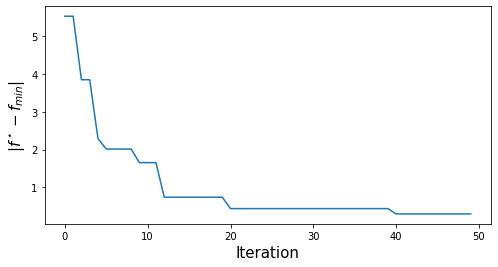

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.minimum.accumulate(np.abs(Ytr - f.yopt)))
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('$|f^\star - f_{min}|$', fontsize=15)
plt.show()